In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import xgboost as xgb

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df1 = pd.read_pickle('person_purchased.pkl')
df1.shape

(116483, 23)

In [3]:
df2 = pd.read_pickle('person_not.pkl')
df2.shape

(689983, 23)

In [4]:
df = pd.concat([df1, df2], axis=0)

In [5]:
df.shape

(806466, 23)

In [6]:
df["has_purchased"].value_counts()

0    689983
1    116483
Name: has_purchased, dtype: int64

In [7]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 806466 entries, 0 to 689982
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   person_id                   806466 non-null  object 
 1   first_utm_medium            548495 non-null  object 
 2   first_utm_source            548527 non-null  object 
 3   multi_device                806466 non-null  int64  
 4   session_count               806466 non-null  int64  
 5   last_utm_medium             624153 non-null  object 
 6   last_utm_source             624184 non-null  object 
 7   source_category             806466 non-null  object 
 8   source_category_2           440350 non-null  object 
 9   source_category_3           97885 non-null   object 
 10  seconds_since_first_vist    806466 non-null  float64
 11  first_utm_content_distinct  806466 non-null  int64  
 12  first_utm_medium_distinct   806466 non-null  int64  
 13  first_utm_sour

## Pearson's Correlation Heatmap

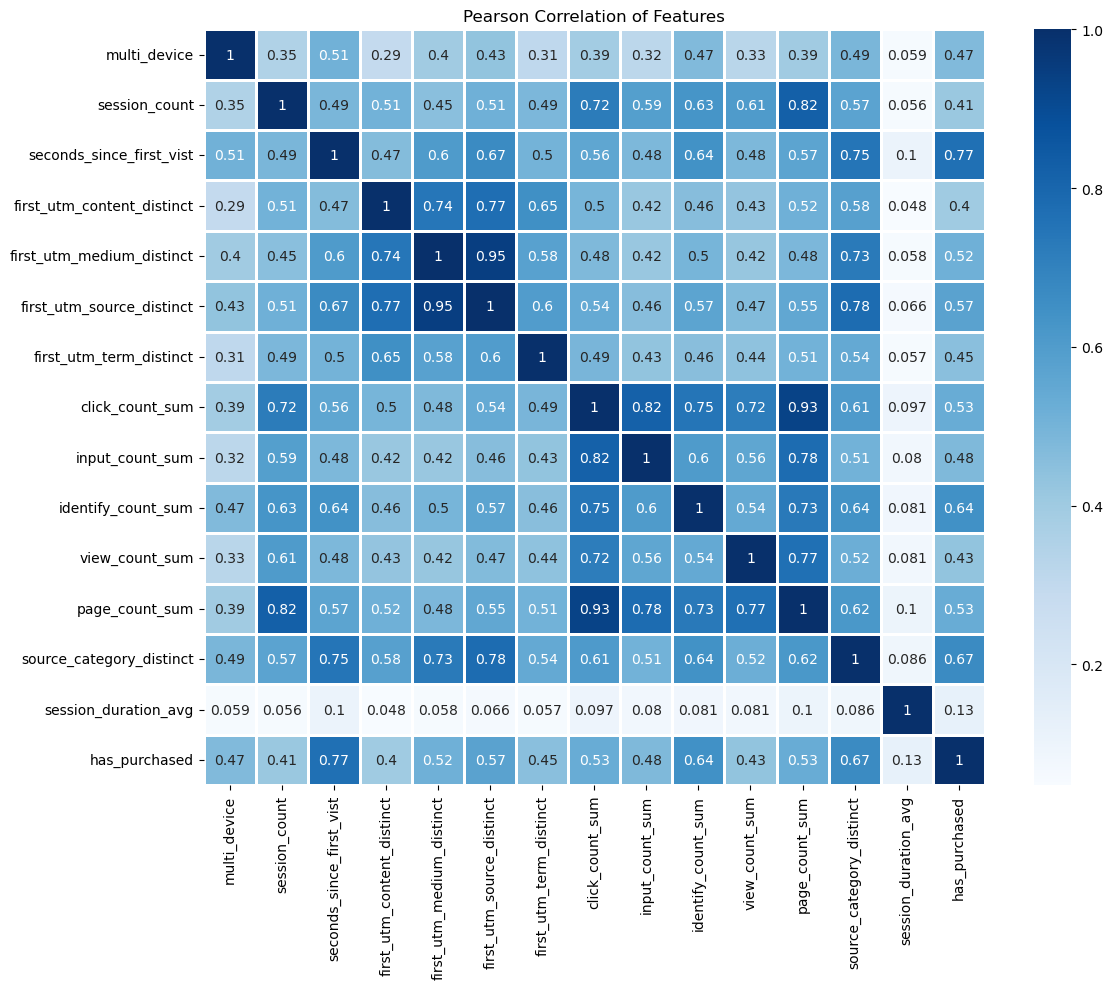

In [8]:
corr = df.corr(numeric_only=True)

f, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(corr, cmap="Blues", annot=True, square=False, ax=ax,  linewidth = 1)
plt.title('Pearson Correlation of Features')
plt.tight_layout()
plt.savefig('02_correlation_matrix.png', dpi=300);

In [11]:
df_y = df['has_purchased']
df_X = df.drop(columns=['has_purchased', 'person_id', 'identify_count_sum'])

### Show an Example Record

In [12]:
df_X.iloc[0]

first_utm_medium               google_ads
first_utm_source                   search
multi_device                            0
session_count                           5
last_utm_medium                google_ads
last_utm_source                   display
source_category               Paid Search
source_category_2                 Branded
source_category_3                    None
seconds_since_first_vist      20218985.28
first_utm_content_distinct              1
first_utm_medium_distinct               1
first_utm_source_distinct               2
first_utm_term_distinct                 1
click_count_sum                        48
input_count_sum                         4
view_count_sum                          1
page_count_sum                         72
source_category_distinct                4
session_duration_avg                  4.6
Name: 0, dtype: object

## Preprocessing

In [13]:
# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)

In [14]:
# count examples in each class
counter = Counter(df_y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 5.923


In [15]:
def create_pipe(clf):

    column_trans = ColumnTransformer(transformers=
        [('num', MinMaxScaler(), selector(dtype_include='number')),
        ('cat', OneHotEncoder(dtype='int', handle_unknown='ignore'), selector(dtype_include="object"))],
        remainder='passthrough', verbose_feature_names_out=True)

    pipeline = Pipeline([('prep',column_trans), ('clf', clf)])

    return pipeline

## Evaluate Final Model

In [16]:
clf = xgb.XGBClassifier(random_state=42, 
                        verbosity=0, 
                        objective='binary:logistic',
                        scale_pos_weight=estimate,
                        n_estimators=1000, 
                        max_depth=6, 
                        learning_rate=0.5)

pipeline = create_pipe(clf)

In [17]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
        
    Source: https://johaupt.github.io/blog/columnTransformer_feature_names.html
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names_out'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names_out. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names_out()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [18]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x28b73c8b0>),
                                                 ('cat',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x28b73c640>)])),
                ('clf',
                 XGBClassifier(base_sco...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.5,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=1000, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=42, ...))])

In [19]:
feat_list = []
xgb_cols = get_feature_names(pipeline['prep'])
feat_imp = pipeline['clf'].feature_importances_

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(xgb_cols, feat_imp):
    feat_list.append(feature)
    total_importance += feature[1]
        
# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['SUMMED_TOTAL'] = df_imp['IMPORTANCE'].cumsum()
df_imp.head(10)

,FEATURE,IMPORTANCE,SUMMED_TOTAL
8,num__input_count_sum,0.347971,0.347971
223,cat__source_category_2_PLA,0.036441,0.384412
10,num__page_count_sum,0.034109,0.418520
180,cat__last_utm_source_display,0.020951,0.439472
230,cat__source_category_2_SMS,0.019759,0.459230
207,cat__source_category_Direct,0.019380,0.478610
162,cat__last_utm_medium_None,0.015820,0.494430
182,cat__last_utm_source_facebook,0.015337,0.509767
0,num__multi_device,0.013785,0.523552
81,cat__first_utm_source_email,0.013697,0.537249


In [ ]:
df_imp.to_csv('02_xgb_feature_importance.csv', index=False)

## Test the Model

In [20]:
def print_confusion(pipeline):
    ''' take a supplied pipeline and run it against the train-test spit 
    and product scoring results.'''
    
    y_pred = pipeline.predict(X_test)

    print(metrics.classification_report(y_test, y_pred, digits=3))
        
    ConfusionMatrixDisplay.from_predictions(y_test, 
                                            y_pred, 
                                            cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('02_confusion_matrix.png', dpi=300);

              precision    recall  f1-score   support

           0      0.988     0.969     0.978    206899
           1      0.836     0.930     0.881     35041

    accuracy                          0.963    241940
   macro avg      0.912     0.950     0.930    241940
weighted avg      0.966     0.963     0.964    241940



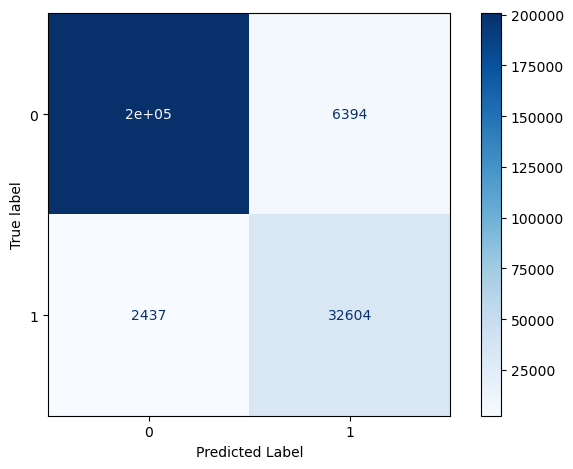

In [22]:
print_confusion(pipeline)

In [ ]:
# Save the model to disk
dump(pipeline, '02_tf_first_purchase.joblib') 